In [3]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("/Users/juliusvlassenroot/code/delaunan/clintrialpredict/data/project/00_data/project_data.csv")


FileNotFoundError: [Errno 2] No such file or directory: '/Users/juliusvlassenroot/code/delaunan/clintrialpredict/data/project/00_data/project_data.csv'

In [4]:
data.columns

NameError: name 'data' is not defined

In [17]:
numeric_df = data.select_dtypes(include=['number'])
numeric_df.columns


Index(['number_of_arms', 'target', 'start_year', 'competition_broad',
       'competition_niche', 'num_primary_endpoints', 'min_p_value',
       'phase_ordinal', 'covid_exposure', 'is_international'],
      dtype='object')

In [21]:
categorical_cols = data.columns.difference(numeric_df.columns)
categorical_cols

Index(['adult', 'agency_class', 'allocation', 'best_pathology', 'child',
       'gender', 'healthy_volunteers', 'intervention_model', 'masking',
       'nct_id', 'older_adult', 'overall_status', 'phase', 'primary_purpose',
       'study_type', 'therapeutic_area', 'therapeutic_subgroup',
       'therapeutic_subgroup_name', 'txt_criteria', 'txt_tags', 'why_stopped'],
      dtype='object')

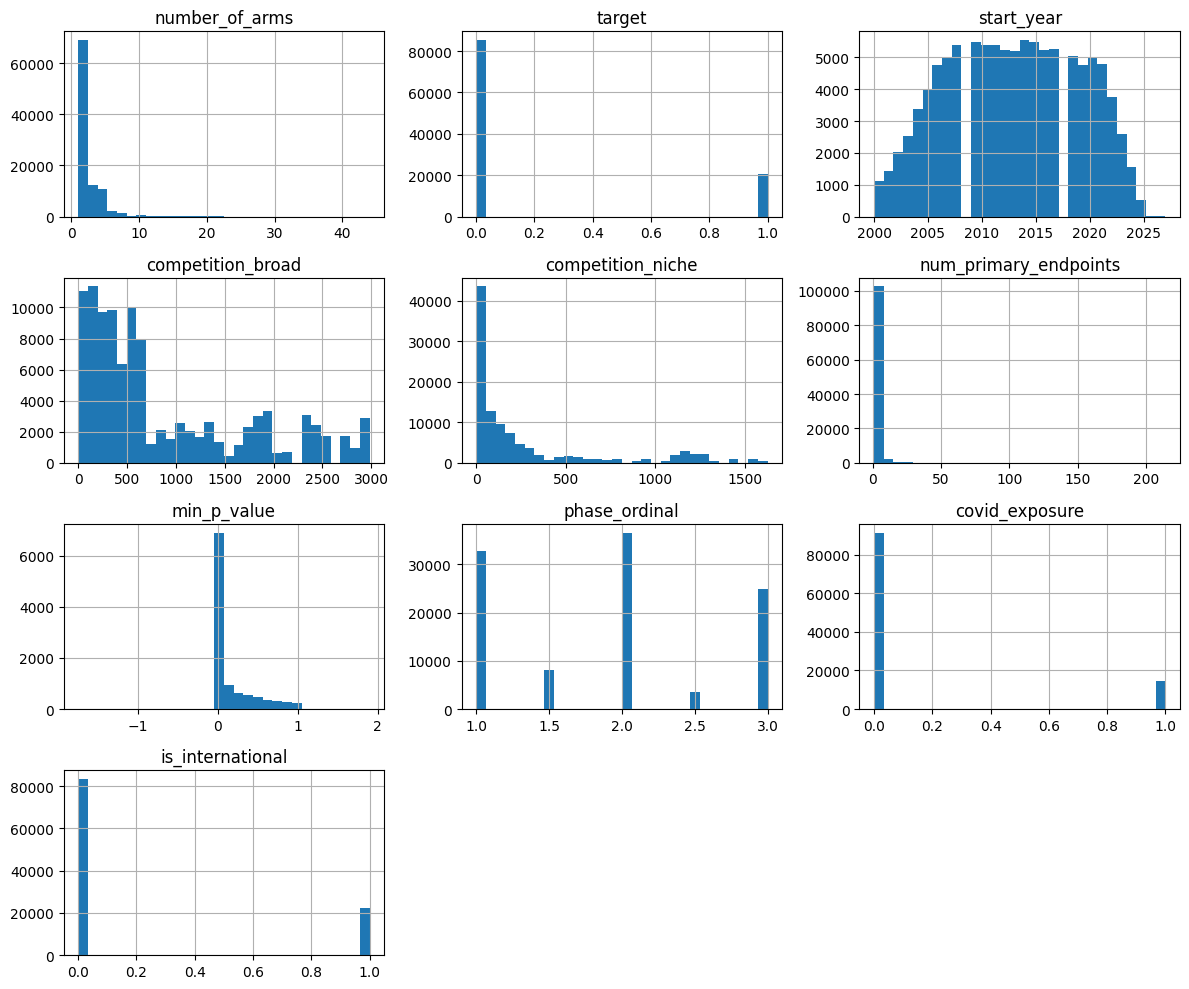

In [4]:
numeric_df.hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()

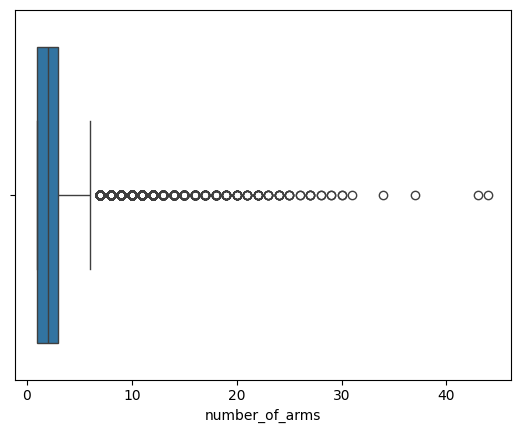

In [7]:
import seaborn as sns
sns.boxplot(x=data["number_of_arms"])
plt.show()


#### So in the distributions, it is visble that:
#### - We can drop target, covid exposure, is_international and min_p_value because they are binary or too many values missing.
#### - competition_niche, competition_broad, num_primary_endpoints, number_of_arms are strongly skewed, long-tailed. So best to Log transform + Standard Scaler (or RobustScaler).
#### - start_year: no skew, bassically symmetric, StandardScaler would be best.
#### - phase_ordinal is not really skewed and do not contain extreme outliers. So MinMax scaling best to keep relative spacing intact.


In [8]:
cols_to_drop = ["target", "covid_exposure", "is_international", "min_p_value"]

num_df = numeric_df.drop(columns=cols_to_drop)


In [15]:
num_df.columns

Index(['number_of_arms', 'start_year', 'competition_broad',
       'competition_niche', 'num_primary_endpoints', 'phase_ordinal'],
      dtype='object')

In [31]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

#These are the different numeric columns that need to pass through different branches of the pipeline
log_trans_cols = ['competition_niche', 'competition_broad', 'num_primary_endpoints', 'number_of_arms']
stand_scal_cols = ["start_year"]
min_max_cols = ["phase_ordinal"]

cat_binary_cols = ['is_international', 'covid_exposure', 'healthy_volunteers',
              'adult', 'child', 'older_adult', 'includes_us']

cat_nominal_cols = ['gender', 'agency_class', 'masking', 'intervention_model',
               'primary_purpose', 'therapeutic_area', 'allocation']

cat_high_card_cols = ['therapeutic_subgroup_name', 'best_pathology']

pipe_bin = Pipeline([
    ("imputer",SimpleImputer(strategy='most_frequent')),
    ("encoder",OneHotEncoder(drop='if_binary', dtype=int, handle_unknown='ignore'))]
)

pipe_nom = Pipeline([
    ("imputer",SimpleImputer(strategy='constant', fill_value='UNKNOWN')),
    ("hot_encoder", OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int))]
)

pipe_high = Pipeline([
    ("imputer",SimpleImputer(strategy='constant', fill_value='UNKNOWN')),
    ("target",TargetEncoder(target_type='binary', smooth=10.0, random_state=42))]
)

#Pipeline for highly skewed columns
log_std_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log1p", FunctionTransformer(np.log1p, validate=False)),
    ("scaler", StandardScaler())])

#Pipeline for StandardScaling
std_pipeline = Pipeline([
     ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())])

#Pipeline for MinMax Scaling
minmax_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("scaler", MinMaxScaler())])

scaler = ColumnTransformer(
    transformers=[
        ("log_std", log_std_pipeline, log_trans_cols),
        ("std", std_pipeline, stand_scal_cols),
        ("minmax", minmax_pipeline, min_max_cols),
        ("cat_binary", pipe_bin,cat_binary_cols),
        ("nominal", pipe_nom,cat_nominal_cols),
        ("high_card", pipe_high,cat_high_card_cols)],remainder="passthrough")


In [32]:
scaler

ColumnTransformer(remainder='passthrough',
                  transformers=[('log_std',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('log1p',
                                                  FunctionTransformer(func=<ufunc 'log1p'>)),
                                                 ('scaler', StandardScaler())]),
                                 ['competition_niche', 'competition_broad',
                                  'num_primary_endpoints', 'number_of_arms']),
                                ('std',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scal...
                                                                sparse_output=False))]),
                                 ['gender', 'agency_class', 'masking',
                                  'intervention_model', 'primary_purpose',
                                  'therapeutic_area', 'allocation']),
                                ('high_card',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='UNKNOWN',
                                                                strategy='constant')),
                                                 ('target',
                                                  TargetEncoder(random_state=42,
                                                                smooth=10.0,
                                                                target_type='binary'))]),
                                 ['therapeutic_subgroup_name',
                                  'best_pathology'])])

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

log_reg_model = Pipeline(steps=[
    ("preprocess", scaler),
    ("model", LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l2', C=0.01,max_iter=1000, random_state=42))])

log_reg_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log_std',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log1p',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['competition_niche',
                                                   'competition_broad',
                                                   'num_primary_endpoints',
                                                   'number_of_arms']),
                                                 ('std',
                                                  Pipeline(steps=[('im...
                                                   'allocation']),
                                                 ('high_card',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='UNKNOWN',
                                                                                 strategy='constant')),
                                                                  ('target',
                                                                   TargetEncoder(random_state=42,
                                                                                 smooth=10.0,
                                                                                 target_type='binary'))]),
                                                  ['therapeutic_subgroup_name',
                                                   'best_pathology'])])),
                ('model',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=1000, random_state=42,
                                    solver='liblinear'))])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

numeric_cols =['number_of_arms', 'target', 'start_year', 'competition_broad',
       'competition_niche', 'num_primary_endpoints', 'min_p_value',
       'phase_ordinal', 'covid_exposure', 'is_international']


preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)
xgboost_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
))])


In [23]:
xgboost_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['number_of_arms', 'target',
                                                   'start_year',
                                                   'competition_broad',
                                                   'competition_niche',
                                                   'num_primary_endpoints',
                                                   'min_p_value',
                                                   'phase_ordinal',
                                                   'covid_exposure',
                                                   'is_international']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['adult', 'agency_class', 'allocation', 'best_...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=2000,
                               n_jobs=-1, num_parallel_tree=None,
                               random_state=42, ...))])